In [1]:
import sys
sys.path.append('../')
from resp import responsibility

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [3]:
passes_df = pd.read_csv(PASSES_DF_PATH)
xt_table = pd.read_csv(XT_PLOT_PATH)

In [4]:
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
cell_width = pitch_length / xt_table.shape[1]
cell_height = pitch_width / xt_table.shape[0]

def adjust_coordinates(x, y, direction):
    if direction == 'TOP_TO_BOTTOM':
        x = - x + pitch_length/2
        y = -y + pitch_width/2
    elif direction == 'BOTTOM_TO_TOP':
        x = x + pitch_length/2
        y = y + pitch_width/2
    return x, y

def get_xt_index(x, y, direction):
    x_adj, y_adj = adjust_coordinates(x, y, direction)
    x_index = int(min(x_adj // cell_width, xt_table.shape[1] - 1))
    y_index = int(min(y_adj // cell_height, xt_table.shape[0] - 1))
    return x_index, y_index

def get_xt_value(x, y, direction):
    x_index, y_index = get_xt_index(x, y, direction)
    return xt_table.iat[y_index, x_index]

def get_dxt(x_start, y_start, x_end, y_end, direction):
    start_xt = get_xt_value(x_start, y_start, direction)
    end_xt = get_xt_value(x_end, y_end, direction)
    return end_xt - start_xt

In [5]:
def passers_expected_threat(defender_x, defender_y, defender_id, recipients, defenders, passer_location):
    
    defenders.loc[defenders['tracking.object_id'] == defender_id, ['tracking.x', 'tracking.y']] = [defender_x, defender_y]

    expected_threat_dict = {}
    threat_dict = {}
    prob_dict = {}
    for _, recipient in recipients.iterrows():
        
        # Threat of the pass
        threat_of_pass = recipient['threat_of_pass']
        
        # Pass success probability
        defenders['pass.endLocation.x'] = recipient['tracking.x']
        defenders['pass.endLocation.y'] = recipient['tracking.y']
        prob_success = 1
        for _, defender in defenders.iterrows(): 
            resp_value = responsibility(defender)
            prob_success *= (1 - resp_value)

        threat_dict[recipient['tracking.object_id']] = threat_of_pass
        prob_dict[recipient['tracking.object_id']] = prob_success
        
        # Expected threat
        expected_threat = threat_of_pass * prob_success
        expected_threat_dict[recipient['tracking.object_id']] = expected_threat
        
    return expected_threat_dict, threat_dict, prob_dict

def defender_true_location(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    return data[data['tracking.object_id'] == defender_id][['tracking.x', 'tracking.y']].values[0]

def get_attacker_locations(data, frame_id):
    data = data[data['frame'] == frame_id]
    return data[data['tracking.is_teammate'] & ~data['tracking.is_self']][['tracking.x', 'tracking.y']].values

def get_defender_locations(data, frame_id):
    data = data[data['frame'] == frame_id]
    return data[~data['tracking.is_teammate'] & ~data['tracking.is_self']][['tracking.x', 'tracking.y']].values

def create_opt_func(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    recipients = data[data['tracking.is_teammate'] & ~data['tracking.is_self']].copy()
    defenders = data[~data['tracking.is_teammate'] & ~data['tracking.is_self']].copy()
    passer_location = data[['location.x', 'location.y']].values[0]
    play_direction =  data['play_direction'].values[0]
    threats = []
    for _, recipient in recipients.iterrows():
        recipient_location = recipient['tracking.x'], recipient['tracking.y']
        threats.append(get_dxt(*passer_location, *recipient_location, play_direction))
    recipients['threat_of_pass'] = threats
    def opt_func(x,y):
        return passers_expected_threat(x, y, defender_id, recipients, defenders, passer_location)
    return opt_func

In [6]:
def plot_frame(data, frame_id):
    data = data[data['frame'] == frame_id]
    data = data[data['tracking.object_id'] != -1]
    _, ax = plt.subplots()
    ax.set_xlim([-pitch_length/2, pitch_length/2])
    ax.set_ylim([-pitch_width/2, pitch_width/2])
    
    # Create a dictionary to store the labels
    labels = {'Passer': None, 'Teammate': None, 'Opponent': None}
    
    for _, player in data.iterrows():
        x, y = player['tracking.x'], player['tracking.y']
        if player['tracking.is_self']:
            color = 'green'
            marker = 'D'
            label = 'Passer'
        elif player['tracking.is_teammate']:
            color = 'blue'
            marker = 'D'
            label = 'Teammate'
        else:
            color = 'red'
            marker = 'o'
            label = 'Opponent'
        # Plot the player and store the label if not already stored
        scatter = ax.scatter(x, y, color=color, marker=marker)
        # anotate defenders only
        if not player['tracking.is_teammate']:
            ax.annotate(player['tracking.object_id'], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        if labels[label] is None:
            labels[label] = scatter
            
    # Add arrow indicating direction of play
    direction = data['play_direction'].values[0]
    if direction == 'TOP_TO_BOTTOM':
        # right to left arrow
        ax.arrow(pitch_length/2, 0, -pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')
    else:
        # left to right arrow
        ax.arrow(-pitch_length/2, 0, pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')

    # Create the legend
    ax.legend(labels.values(), labels.keys())
    plt.show()

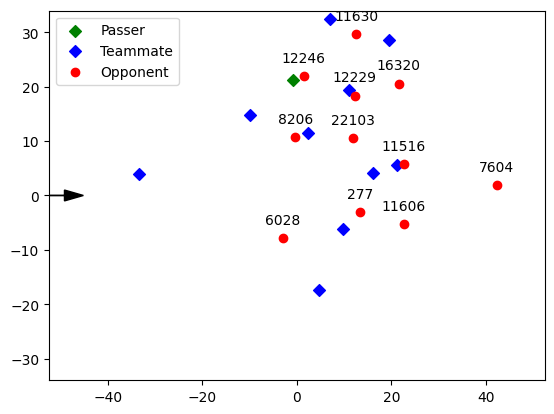

In [ ]:
# frame_id = np.random.choice(passes_df['frame'].unique())
frame_id = 48981
plot_frame(passes_df, frame_id)

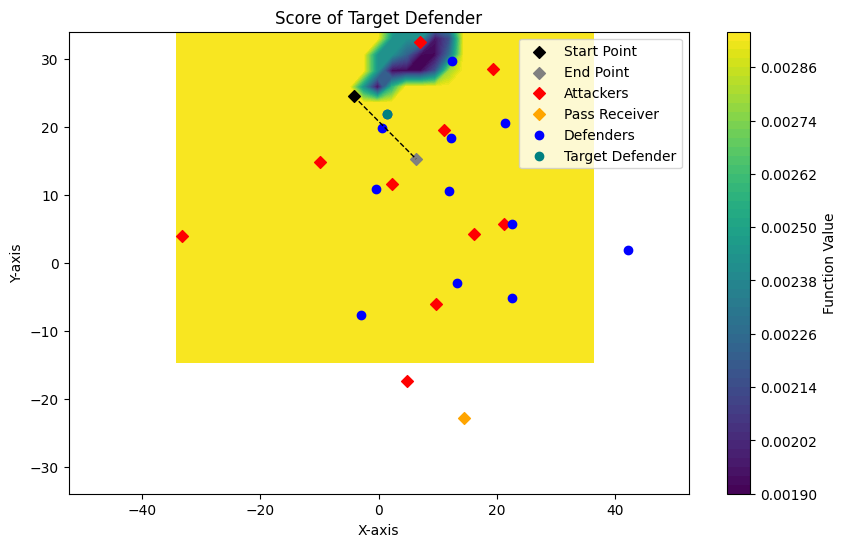

In [11]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)

# Define the point around which the function will be visualized
x_origin, y_origin = defender_true_location(passes_df, frame_id, defender_id)
true_scores,_,_ = opt_func(x_origin, y_origin)
true_score = max(true_scores.values())
pass_receiver = max(true_scores, key=true_scores.get)

# Define pass start and end points
x_start, y_start = passes_df[passes_df['frame'] == frame_id][['location.x', 'location.y']].values[0]
x_end, y_end = passes_df[passes_df['frame'] == frame_id][['pass.endLocation.x', 'pass.endLocation.y']].values[0]

# Create a meshgrid around the origin point
x = np.linspace(min(x_origin, x_start, x_end) - 30, max(x_origin, x_start, x_end) + 30,30)
y = np.linspace(min(y_origin, y_start, y_end) - 30, max(y_origin, y_start, y_end) + 30,30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = max(opt_func(X[i,j],Y[i,j])[0].values())

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

# Plot the pass
plt.scatter(x_start, y_start, color='black', marker='D', label='Start Point')
plt.scatter(x_end, y_end, color='grey', marker='D', label='End Point')
plt.plot([x_start, x_end], [y_start, y_end], color='black', linestyle='dashed', linewidth=1)

# Plot attackers
attackers = get_attacker_locations(passes_df, frame_id)
plt.scatter(attackers[:,0], attackers[:,1], color='red', marker='D', label='Attackers')

# Plot pass receiver
pass_receiver_x, pass_receiver_y = passes_df[passes_df['tracking.object_id'] == pass_receiver][['tracking.x', 'tracking.y']].values[0]
plt.scatter(pass_receiver_x, pass_receiver_y, color='orange', marker='D', label='Pass Receiver')

# Plot defenders
defenders = get_defender_locations(passes_df, frame_id)
plt.scatter(defenders[:,0], defenders[:,1], color='blue', label='Defenders')

# Plot target defender
plt.scatter(x_origin, y_origin, color='teal', label='Target Defender')

plt.legend()
plt.title('Score of Target Defender')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

/var/folders/53/t55qdy3d6n5fqv80nztwthtr0000gn/T/ipykernel_62415/3376754008.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_labels)


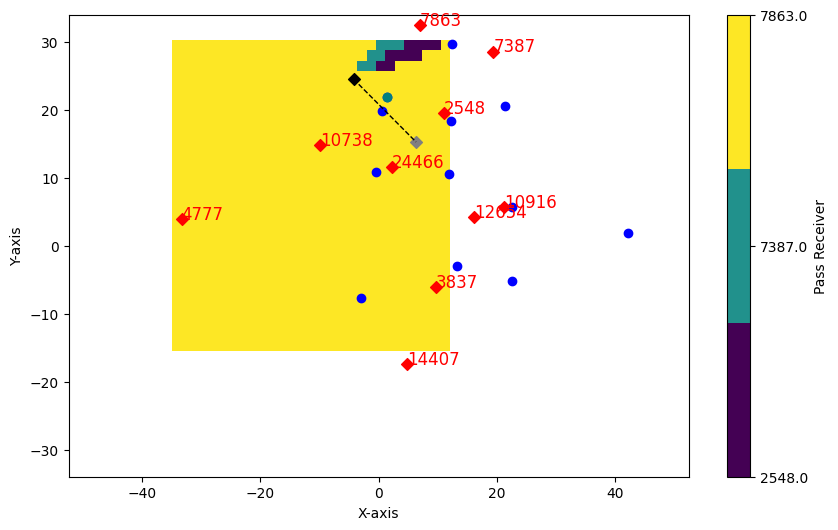

In [13]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)

# Define the point around which the function will be visualized
x_origin, y_origin = defender_true_location(passes_df, frame_id, defender_id)
true_scores,_,_ = opt_func(x_origin, y_origin)
true_score = max(true_scores.values())
pass_receiver = max(true_scores, key=true_scores.get)

# Define pass start and end points
x_start, y_start = passes_df[passes_df['frame'] == frame_id][['location.x', 'location.y']].values[0]
x_end, y_end = passes_df[passes_df['frame'] == frame_id][['pass.endLocation.x', 'pass.endLocation.y']].values[0]

# Create a meshgrid around the origin point
x = np.linspace(min(x_origin, x_start, x_end) - 30, max(x_origin, x_start, x_end) + 5, 30)
y = np.linspace(min(y_origin, y_start, y_end) - 30, max(y_origin, y_start, y_end) + 5, 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
P = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        true_scores = opt_func(X[i,j],Y[i,j])[0]
        Z[i, j] = max(true_scores.values())
        P[i, j] = max(true_scores, key=true_scores.get)  

unique_labels = np.unique(P)
num_labels = len(unique_labels)

# Map labels to class numbers
label_to_class = {label: idx for idx, label in enumerate(unique_labels)}
class_to_label = {idx: label for idx, label in enumerate(unique_labels)}

# Replace values in P with class numbers
P_class = np.vectorize(label_to_class.get)(P)

# Create a colormap with a unique color for each class
cmap = plt.cm.get_cmap('viridis', num_labels)

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(X, Y, P_class, cmap=cmap, shading='auto')

# Create a colorbar with original labels
cbar = plt.colorbar(mesh, ticks=np.arange(num_labels))
cbar.ax.set_yticklabels([str(class_to_label[i]) for i in range(num_labels)])
cbar.set_label('Pass Receiver')

# Plot the pass
plt.scatter(x_start, y_start, color='black', marker='D', label='Start Point')
plt.scatter(x_end, y_end, color='grey', marker='D', label='End Point')
plt.plot([x_start, x_end], [y_start, y_end], color='black', linestyle='dashed', linewidth=1)

# Plot attackers with id information
attackers = get_attacker_locations(passes_df, frame_id)
attacker_ids = passes_df[(passes_df['frame'] == frame_id) & passes_df['tracking.is_teammate'] & ~passes_df['tracking.is_self']]['tracking.object_id']
plt.scatter(attackers[:,0], attackers[:,1], color='red', marker='D', label='Attackers')
for i in range(len(attackers)):
    plt.text(attackers[i][0], attackers[i][1], str(attacker_ids.iloc[i]), fontsize=12, color='red')


# Plot defenders
defenders = get_defender_locations(passes_df, frame_id)
plt.scatter(defenders[:,0], defenders[:,1], color='blue', label='Defenders')

# Plot target defender
plt.scatter(x_origin, y_origin, color='teal', label='Origin Point')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])

plt.show()